## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from sklearn.linear_model import LinearRegression
from scipy import stats
from sklearn.metrics import mean_squared_error, r2_score
import tensorflow as tf
import datetime as dt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Normalization


## Load Data

In [2]:
high_altitude = pd.read_csv("./data/measurements-high-altitude.csv")
low_altitude = pd.read_csv("./data/measurements-low-altitude.csv")

## Data cleanup

In [3]:
list(high_altitude)

['hour',
 ' minute',
 ' second',
 ' azimuth angle (relative to west=0)/degree',
 ' elevation angle/degree',
 ' power/mW']

In [4]:
high_altitude.rename(columns={" power/mW" : "power", " azimuth angle (relative to west=0)/degree" : "azimuth", " elevation angle/degree" : "elevation"}, inplace = True)
high_altitude.columns = high_altitude.columns.str.replace(" ", "")

low_altitude.rename(columns={" power/mW" : "power", " azimuth angle (relative to west=0)/degree" : "azimuth", " elevation angle/degree" : "elevation"}, inplace = True)
low_altitude.columns = low_altitude.columns.str.replace(" ", "")

In [5]:
high_altitude.head()

,hour,minute,second,azimuth,elevation,power
0,9,45,5,0,0,32
1,9,45,9,0,15,879
2,9,45,12,0,30,34
3,9,45,15,0,45,35
4,9,45,18,0,60,51


In [6]:
low_altitude.head()

,hour,minute,second,azimuth,elevation,power
0,10,38,3,0,0,56
1,10,38,7,0,15,57
2,10,38,10,0,30,59
3,10,38,14,0,45,57
4,10,38,16,0,60,83


In [7]:
high_altitude.describe()

,hour,minute,second,azimuth,elevation,power
count,2469.000000,2469.000000,2469.000000,2469.000000,2469.000000,2469.000000
mean,11.735925,29.474281,29.589307,89.467801,45.006075,231.443904
std,1.498760,17.265160,17.289971,57.050976,30.037962,175.365305
min,9.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,11.000000,15.000000,15.000000,36.000000,15.000000,129.000000
50%,12.000000,30.000000,30.000000,90.000000,45.000000,217.000000
75%,13.000000,45.000000,45.000000,144.000000,75.000000,333.000000
max,14.000000,59.000000,59.000000,180.000000,90.000000,4168.000000


In [8]:
high_altitude.loc[high_altitude.power.idxmax(),:]

hour            9
minute         45
second         38
azimuth        18
elevation      45
power        4168
Name: 10, dtype: int64

In [9]:
low_altitude.describe()

,hour,minute,second,azimuth,elevation,power
count,1771.000000,1771.000000,1771.000000,1771.000000,1771.000000,1771.000000
mean,11.880294,30.643139,29.224732,90.000000,45.000000,279.383399
std,1.090955,18.001482,17.335092,56.937075,30.008473,82.632597
min,10.000000,0.000000,0.000000,0.000000,0.000000,41.000000
25%,11.000000,14.000000,14.000000,36.000000,15.000000,225.000000
50%,12.000000,32.000000,29.000000,90.000000,45.000000,302.000000
75%,13.000000,47.000000,44.000000,144.000000,75.000000,352.000000
max,14.000000,59.000000,59.000000,180.000000,90.000000,378.000000


## Convert time in datetime


In [10]:
df = high_altitude.loc[:,['hour', 'minute', 'second']]
l = len(high_altitude)
df['year'] = [2016]*l
df['month'] = [11]*l
df['day'] = [23]*l

high_altitude=high_altitude.set_index(pd.to_datetime(df))
high_altitude

,hour,minute,second,azimuth,elevation,power
2016-11-23 09:45:05,9,45,5,0,0,32
2016-11-23 09:45:09,9,45,9,0,15,879
2016-11-23 09:45:12,9,45,12,0,30,34
2016-11-23 09:45:15,9,45,15,0,45,35
2016-11-23 09:45:18,9,45,18,0,60,51
...,...,...,...,...,...,...
2016-11-23 14:46:27,14,46,27,36,90,172
2016-11-23 14:46:30,14,46,30,54,0,108
2016-11-23 14:46:35,14,46,35,54,15,159
2016-11-23 14:46:38,14,46,38,54,30,213


In [11]:
df = low_altitude.loc[:,['hour', 'minute', 'second']]
l = len(low_altitude)
df['year'] = [2016]*l
df['month'] = [11]*l
df['day'] = [23]*l

low_altitude=low_altitude.set_index(pd.to_datetime(df))
low_altitude

,hour,minute,second,azimuth,elevation,power
2016-11-23 10:38:03,10,38,3,0,0,56
2016-11-23 10:38:07,10,38,7,0,15,57
2016-11-23 10:38:10,10,38,10,0,30,59
2016-11-23 10:38:14,10,38,14,0,45,57
2016-11-23 10:38:16,10,38,16,0,60,83
...,...,...,...,...,...,...
2016-11-23 14:09:04,14,9,4,180,30,278
2016-11-23 14:09:07,14,9,7,180,45,281
2016-11-23 14:09:10,14,9,10,180,60,274
2016-11-23 14:09:13,14,9,13,180,75,253


### Convert time in seconds

### Removing outliers from high_altitude

In [12]:
print(high_altitude.shape)
high_altitude = high_altitude[(np.abs(stats.zscore(high_altitude)) < 3).all(axis=1)]
print(high_altitude.shape)

(2469, 6)
(2459, 6)


In [13]:
high_altitude

,hour,minute,second,azimuth,elevation,power
2016-11-23 09:45:05,9,45,5,0,0,32
2016-11-23 09:45:12,9,45,12,0,30,34
2016-11-23 09:45:15,9,45,15,0,45,35
2016-11-23 09:45:18,9,45,18,0,60,51
2016-11-23 09:45:21,9,45,21,0,75,76
...,...,...,...,...,...,...
2016-11-23 14:46:27,14,46,27,36,90,172
2016-11-23 14:46:30,14,46,30,54,0,108
2016-11-23 14:46:35,14,46,35,54,15,159
2016-11-23 14:46:38,14,46,38,54,30,213


### Plots

<AxesSubplot:title={'center':'High Altitude Peak Power Measurements'}>

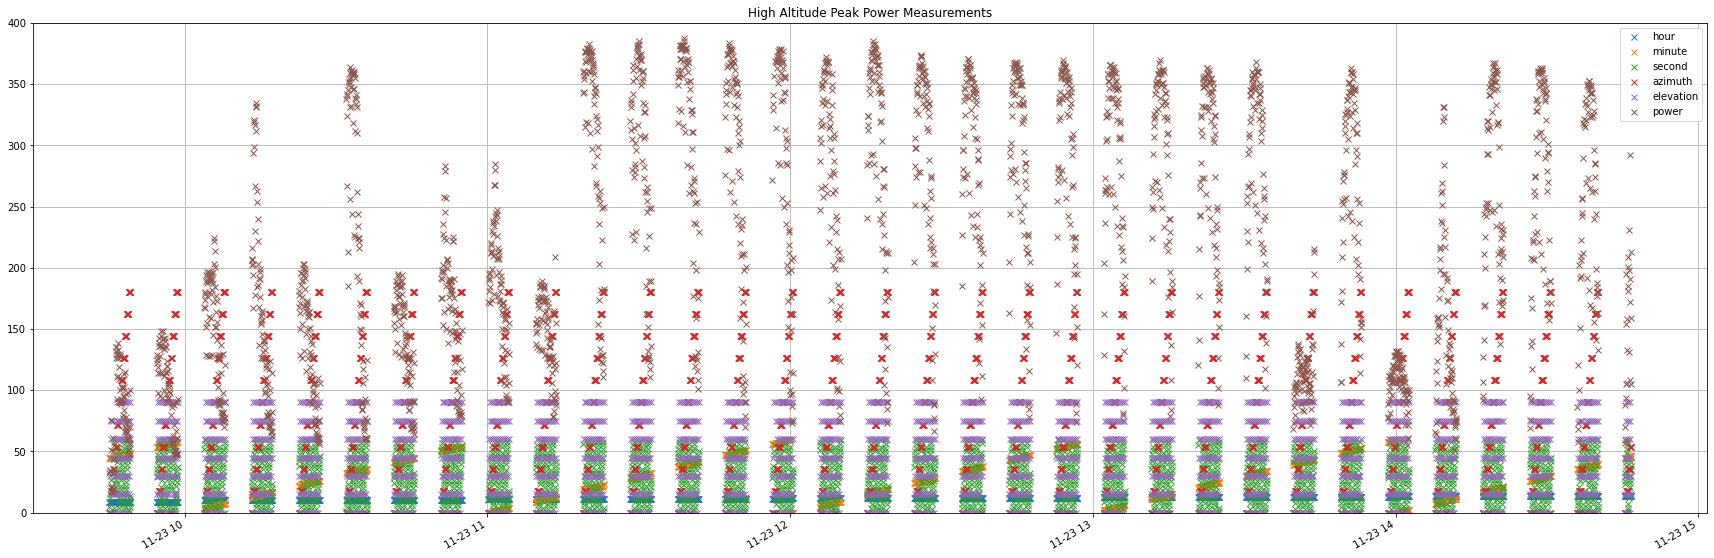

In [14]:
high_altitude.plot(figsize=(30,10), title='High Altitude Peak Power Measurements', grid=True, marker='x', markersize=6, linestyle='None', ylim=(0,400))

<AxesSubplot:title={'center':'Low Altitude Peak Power Measurements'}>

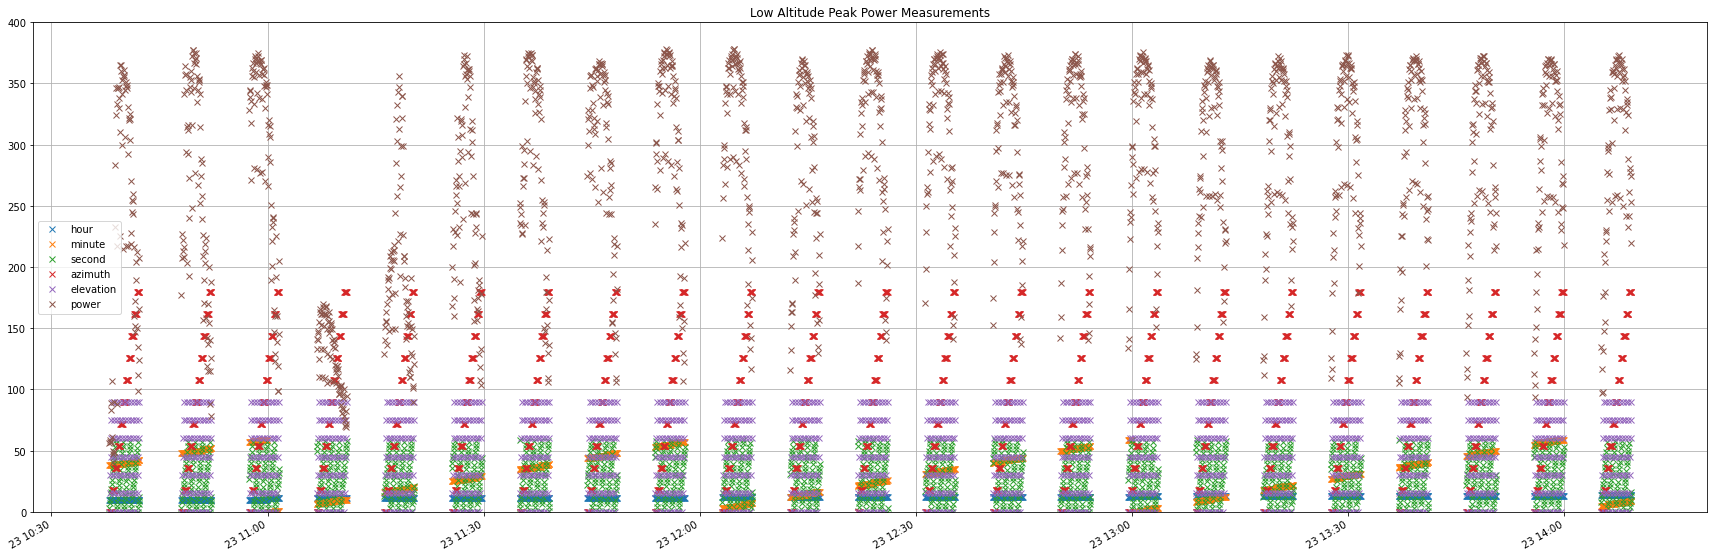

In [15]:
low_altitude.plot(figsize=(30,10), title='Low Altitude Peak Power Measurements', grid=True, marker='x', markersize=6, linestyle='None', ylim=(0,400))

## Train test split

In [19]:
X_low_train = low_altitude.sample(frac=0.8, random_state=2)
X_low_test = low_altitude.drop(X_low_train.index)

y_low_train = X_low_train.pop("power")
y_low_test = X_low_test.pop("power")

In [20]:
X_high_train = high_altitude.sample(frac=0.8, random_state=2)
X_high_test = high_altitude.drop(X_high_train.index)

y_high_train = X_high_train.pop("power")
y_high_test = X_high_test.pop("power")

In [21]:
y_low_train.describe()

count    1417.000000
mean      279.540579
std        82.386542
min        49.000000
25%       227.000000
50%       301.000000
75%       351.000000
max       378.000000
Name: power, dtype: float64

In [22]:
y_high_train.describe()

count    1967.000000
mean      224.564311
std       104.227067
min         0.000000
25%       129.000000
50%       216.000000
75%       333.000000
max       388.000000
Name: power, dtype: float64

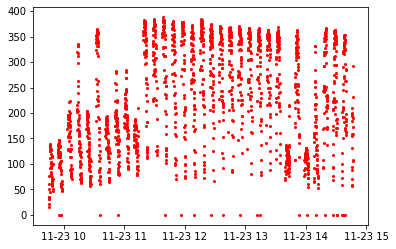

In [23]:
plt.plot(y_high_train, 'or', markersize=2)

In [24]:
normalizer_low = Normalization(axis=-1)
normalizer_low.adapt(np.array(X_low_train))

print(normalizer_low.mean.numpy())

2022-07-12 12:32:07.134387: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-07-12 12:32:07.134656: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-07-12 12:32:07.177872: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-07-12 12:32:07.244142: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-12 12:32:07.257039: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB

[[11.871558 30.616798 29.044462 88.81864  45.719826]]


In [25]:
first_sample = np.array(X_low_train[:1])

with np.printoptions(precision=2, suppress=True):
  print(np.sort(first_sample))
  print(np.sort(normalizer_low(first_sample).numpy()))


[[ 0 11 15 26 44]]
[[-1.56 -1.02 -0.8  -0.18  0.74]]


# Baseline Dataset

## Regression using MLP

In [26]:
def create_regressor(normalizer):
  reg = Sequential([
  normalizer,
  Dense(units=256, activation='relu'),
  Dropout(0.3),
  Dense(units=128, activation='relu'),
  Dense(units=1)
])

  return reg

In [27]:
callbacks=[tf.keras.callbacks.ReduceLROnPlateau(min_lr=1e-10, verbose=1), tf.keras.callbacks.EarlyStopping(patience=30)]
metrics = [tf.keras.metrics.MeanSquaredError()]

In [28]:
def plot_metrics(history):

  fig, (ax1, ax2) = plt.subplots(1, 2)
  fig.set_size_inches(20,10)
  ax1.plot(history.history['loss'], label='loss')
  ax1.plot(history.history['val_loss'], label='val_loss')
  ax1.set_title('loss (MAE)')
  ax1.set_xlabel('epochs')
  ax1.set_ylabel('error')
  ax1.legend()
  ax1.grid(True)

  ax2.plot(history.history['mean_squared_error'], label='mse')
  ax2.plot(history.history['val_mean_squared_error'], label='val_mse')
  ax2.set_title('metric (MSE)')
  ax2.set_xlabel('epochs')
  ax2.set_ylabel('error')
  ax2.legend()
  ax2.grid(True)

### Regression on Low Altitude

In [29]:
reg_low = create_regressor(normalizer_low)
reg_low.predict(X_low_train[:10])

2022-07-12 12:32:07.634776: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


array([[ 0.12242815],
       [-0.11083279],
       [ 0.10606509],
       [-0.07049257],
       [-0.02257229],
       [-0.12289104],
       [ 0.15685952],
       [ 0.06745135],
       [-0.1232888 ],
       [ 0.11768232]], dtype=float32)

In [30]:
reg_low.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 5)                11        
 n)                                                              
                                                                 
 dense (Dense)               (None, 256)               1536      
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 34,572
Trainable params: 34,561
Non-trainable params: 11
___________________________________________________

In [31]:
reg_low.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.1), loss="mae", metrics=metrics)

In [32]:
history = reg_low.fit(X_low_train, y_low_train, epochs=1000, validation_split=0.2, callbacks=callbacks)

Epoch 1/1000
11/36 [========>.....................] - ETA: 0s - loss: 146.8306 - mean_squared_error: 30774.9180

2022-07-12 12:32:07.942452: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


36/36 [==============================] - 1s 9ms/step - loss: 108.5427 - mean_squared_error: 18278.9004 - val_loss: 69.3321 - val_mean_squared_error: 8466.0586 - lr: 0.1000
Epoch 2/1000
21/36 [================>.............] - ETA: 0s - loss: 79.0850 - mean_squared_error: 9987.3408 

2022-07-12 12:32:08.344667: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


36/36 [==============================] - 0s 6ms/step - loss: 73.8678 - mean_squared_error: 8716.8887 - val_loss: 48.1190 - val_mean_squared_error: 3118.5542 - lr: 0.1000
Epoch 3/1000
36/36 [==============================] - 0s 6ms/step - loss: 52.2633 - mean_squared_error: 4565.4878 - val_loss: 77.8785 - val_mean_squared_error: 9234.7607 - lr: 0.1000
Epoch 4/1000
36/36 [==============================] - 0s 6ms/step - loss: 57.4177 - mean_squared_error: 5237.8105 - val_loss: 34.7125 - val_mean_squared_error: 1900.9949 - lr: 0.1000
Epoch 5/1000
36/36 [==============================] - 0s 6ms/step - loss: 44.3897 - mean_squared_error: 3245.8105 - val_loss: 35.9200 - val_mean_squared_error: 2152.3865 - lr: 0.1000
Epoch 6/1000
36/36 [==============================] - 0s 6ms/step - loss: 39.5467 - mean_squared_error: 2883.5229 - val_loss: 31.5496 - val_mean_squared_error: 1755.6305 - lr: 0.1000
Epoch 7/1000
36/36 [==============================] - 0s 6ms/step - loss: 37.8160 - mean_squared_e

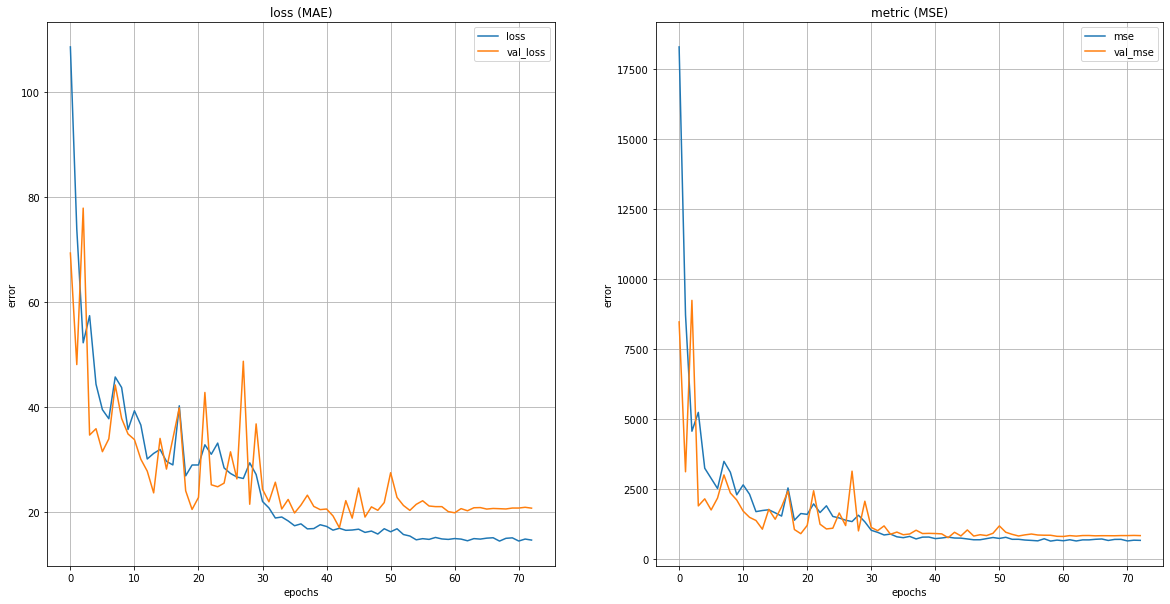

In [33]:
plot_metrics(history)

In [34]:
results = reg_low.evaluate(X_low_test, y_low_test)

12/12 [==============================] - 0s 6ms/step - loss: 20.6364 - mean_squared_error: 830.4291


### Regression on High Altitude

In [35]:
normalizer_high = Normalization(axis=-1)
normalizer_high.adapt(np.array(X_high_train))

print(normalizer_high.mean.numpy())

[[11.747841 29.50585  29.623283 89.49671  45.289783]]


2022-07-12 12:32:25.158241: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-12 12:32:25.168794: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [36]:
first_sample = np.array(X_high_train[:1])

with np.printoptions(precision=2, suppress=True):
  print(np.sort(first_sample))
  print(np.sort(normalizer_high(first_sample).numpy()))

[[ 11  15  40  50 144]]
[[-1.01 -0.5   0.61  0.96  1.17]]


In [37]:
reg_high = create_regressor(normalizer_high)
reg_high.predict(X_high_train[:10])

2022-07-12 12:32:25.406063: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


array([[ 0.13749868],
       [ 0.09021375],
       [ 0.08332359],
       [ 0.00684475],
       [ 0.08060914],
       [-0.11596026],
       [ 0.02168257],
       [ 0.09626028],
       [ 0.14609218],
       [ 0.00819618]], dtype=float32)

In [38]:
reg_high.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normalizat  (None, 5)                11        
 ion)                                                            
                                                                 
 dense_3 (Dense)             (None, 256)               1536      
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_4 (Dense)             (None, 128)               32896     
                                                                 
 dense_5 (Dense)             (None, 1)                 129       
                                                                 
Total params: 34,572
Trainable params: 34,561
Non-trainable params: 11
_________________________________________________

In [39]:
reg_high.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.1), loss='mae', metrics=metrics)

In [40]:
history = reg_high.fit(X_high_train, y_high_train, epochs=1000, validation_split=0.2, callbacks=callbacks)

Epoch 1/1000
20/50 [===========>..................] - ETA: 0s - loss: 122.1245 - mean_squared_error: 15206.3037

2022-07-12 12:32:25.637816: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


50/50 [==============================] - 1s 8ms/step - loss: 104.2177 - mean_squared_error: 14465.0859 - val_loss: 92.9681 - val_mean_squared_error: 14737.1748 - lr: 0.1000
Epoch 2/1000
21/50 [===========>..................] - ETA: 0s - loss: 92.8642 - mean_squared_error: 13831.0537 

2022-07-12 12:32:26.044731: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


50/50 [==============================] - 0s 6ms/step - loss: 81.1405 - mean_squared_error: 10900.6455 - val_loss: 59.0011 - val_mean_squared_error: 6222.3726 - lr: 0.1000
Epoch 3/1000
50/50 [==============================] - 0s 6ms/step - loss: 64.5843 - mean_squared_error: 7305.2827 - val_loss: 52.0571 - val_mean_squared_error: 4514.9336 - lr: 0.1000
Epoch 4/1000
50/50 [==============================] - 0s 6ms/step - loss: 52.5459 - mean_squared_error: 5183.8813 - val_loss: 54.4291 - val_mean_squared_error: 4792.6104 - lr: 0.1000
Epoch 5/1000
50/50 [==============================] - 0s 6ms/step - loss: 63.8323 - mean_squared_error: 7114.8413 - val_loss: 53.7391 - val_mean_squared_error: 4790.2866 - lr: 0.1000
Epoch 6/1000
50/50 [==============================] - 0s 6ms/step - loss: 54.6726 - mean_squared_error: 5530.5044 - val_loss: 52.4204 - val_mean_squared_error: 4213.3516 - lr: 0.1000
Epoch 7/1000
50/50 [==============================] - 0s 6ms/step - loss: 50.0441 - mean_squared_

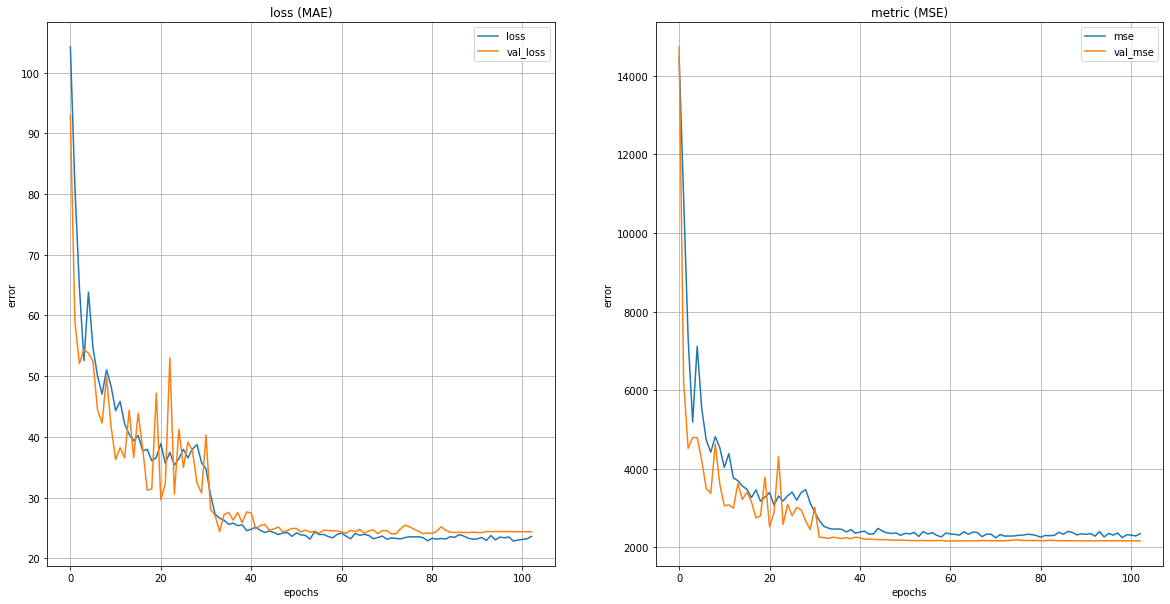

In [41]:
plot_metrics(history)

In [42]:
results = reg_high.evaluate(X_high_test, y_high_test)

16/16 [==============================] - 0s 6ms/step - loss: 25.5664 - mean_squared_error: 2433.2080


## Timeseries Forecasting

✅ Resampled existing dataset but creates NaNs. Rolled back to original dataset

✅ Split dataset in multivariate time series

✅ Trained LSTM

ToDo:
 Forecast LSTM predictions untill 20:00

 Alternative 1:
  - Manually create time, azimuth and elevation vectors for hour range 14:40 - 20:00
  - Use LSTM to predict power given the manually created features
  
Alternative 2:
  - Train LSTM to predict azimuth and elevation as well as power
  - Recursively predict on LSTM predictions till 20:00



<AxesSubplot:title={'center':'High altitude'}>

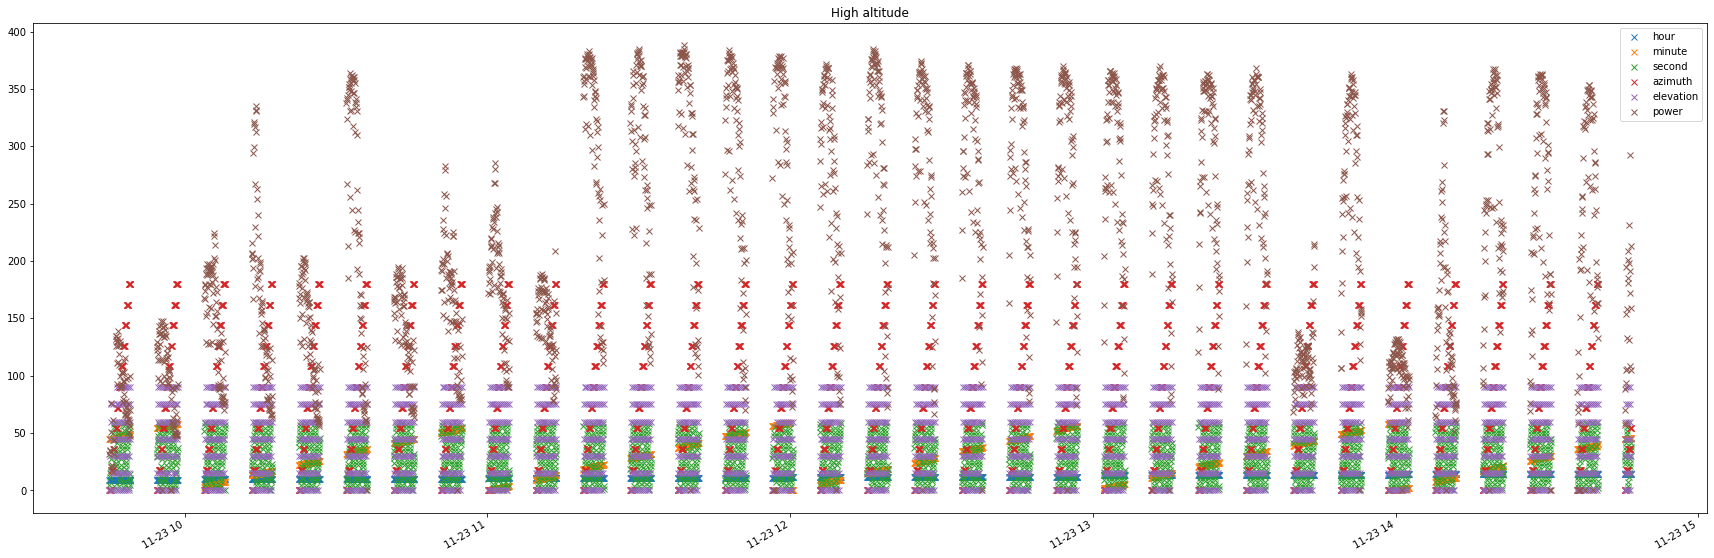

In [25]:
high_altitude.plot(figsize=(30,10), title='High altitude', marker='x', linestyle='None')

In [26]:
# high_altitude_resampled = high_altitude.resample('20S').ffill()
# print(high_altitude_resampled)
# high_altitude_resampled.plot(figsize=(30,10), title='High altitude resampled', marker='x', linestyle='None')

In [27]:
def normalize(df):
  df_std = df.copy()
  for column in df_std.columns[:-1]:
    df_std[column] = df_std[column] / df_std[column].max()
  return df_std

In [30]:
high_altitude_norm = normalize(high_altitude)

In [31]:
high_altitude_norm[high_altitude_norm.isna().any(axis=1)]

,hour,minute,second,azimuth,elevation,power


In [32]:
high_altitude_norm.describe()

,hour,minute,second,azimuth,elevation,power
count,2459.000000,2459.000000,2459.000000,2459.000000,2459.000000,2459.000000
mean,0.839075,0.498466,0.501623,0.498455,0.499458,224.354209
std,0.106542,0.292716,0.293077,0.316725,0.333502,104.092988
min,0.642857,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.785714,0.237288,0.254237,0.200000,0.166667,129.000000
50%,0.857143,0.508475,0.508475,0.500000,0.500000,216.000000
75%,0.928571,0.762712,0.762712,0.800000,0.833333,333.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,388.000000


In [148]:
def df_to_X_y(df, window_size=5):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [r for r in df_as_np[i:i+window_size]]
    X.append(row)
    label = df_as_np[i+window_size][-1]
    y.append(label)
  return np.array(X), np.array(y)

In [149]:
X, y = df_to_X_y(high_altitude)
X.shape, y.shape

((2454, 5, 6), (2454,))

In [154]:
y

array([ 20,  22,  61, ..., 159, 213, 105])

In [150]:
df_len = high_altitude.shape[0]
train = int(df_len * 0.7)
val = int(df_len * 0.9)
X_train, y_train = X[:train], y[:train]
X_val, y_val = X[train:val], y[train:val]
X_test, y_test = X[val:], y[val:]
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((1721, 5, 6), (1721,), (492, 5, 6), (492,), (241, 5, 6), (241,))

In [151]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer,LSTM, Dense
from tensorflow.keras import optimizers

model = Sequential()
model.add(InputLayer((5, 6)))
model.add(LSTM(64))
model.add(Dense(8, 'relu'))
model.add(Dense(1, 'linear'))

model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_7 (LSTM)               (None, 64)                18176     
                                                                 
 dense_14 (Dense)            (None, 8)                 520       
                                                                 
 dense_15 (Dense)            (None, 1)                 9         
                                                                 
Total params: 18,705
Trainable params: 18,705
Non-trainable params: 0
_________________________________________________________________


In [152]:
optimizer = optimizers.Adam()
model.compile(loss='mae', optimizer=optimizer)

In [153]:
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=200)

Epoch 1/200


2022-07-12 17:29:05.588694: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/54 [..............................] - ETA: 42s - loss: 220.3798

2022-07-12 17:29:05.792459: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-12 17:29:05.867500: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


54/54 [==============================] - ETA: 0s - loss: 222.3618

2022-07-12 17:29:07.132101: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-12 17:29:07.199797: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


54/54 [==============================] - 2s 27ms/step - loss: 222.3618 - val_loss: 188.7544
Epoch 2/200
54/54 [==============================] - 1s 10ms/step - loss: 207.5858 - val_loss: 169.9619
Epoch 3/200
54/54 [==============================] - 1s 10ms/step - loss: 186.0443 - val_loss: 145.0301
Epoch 4/200
54/54 [==============================] - 1s 11ms/step - loss: 159.9528 - val_loss: 118.9738
Epoch 5/200
54/54 [==============================] - 1s 10ms/step - loss: 135.7463 - val_loss: 97.1931
Epoch 6/200
54/54 [==============================] - 1s 10ms/step - loss: 113.0171 - val_loss: 85.2718
Epoch 7/200
54/54 [==============================] - 1s 10ms/step - loss: 94.2229 - val_loss: 72.6841
Epoch 8/200
54/54 [==============================] - 1s 10ms/step - loss: 79.2874 - val_loss: 62.1573
Epoch 9/200
54/54 [==============================] - 1s 10ms/step - loss: 68.0635 - val_loss: 53.7602
Epoch 10/200
54/54 [==============================] - 1s 10ms/step - loss: 58.1099 -

In [168]:
def plot_predictions(model, X, y, start=0, end=100):
  predictions = model.predict(X).flatten()
  df = pd.DataFrame(data={'Predictions':predictions, 'Actuals':y})
  df.plot(figsize=(20,10), marker='x', linestyle='--', xlabel='samples',ylabel='power')
  return df

,Predictions,Actuals
0,237.283966,253
1,230.003662,248
2,244.252167,250
3,281.253235,293
4,313.288788,314
...,...,...
236,162.025635,172
237,241.798843,108
238,191.259491,159
239,188.317993,213


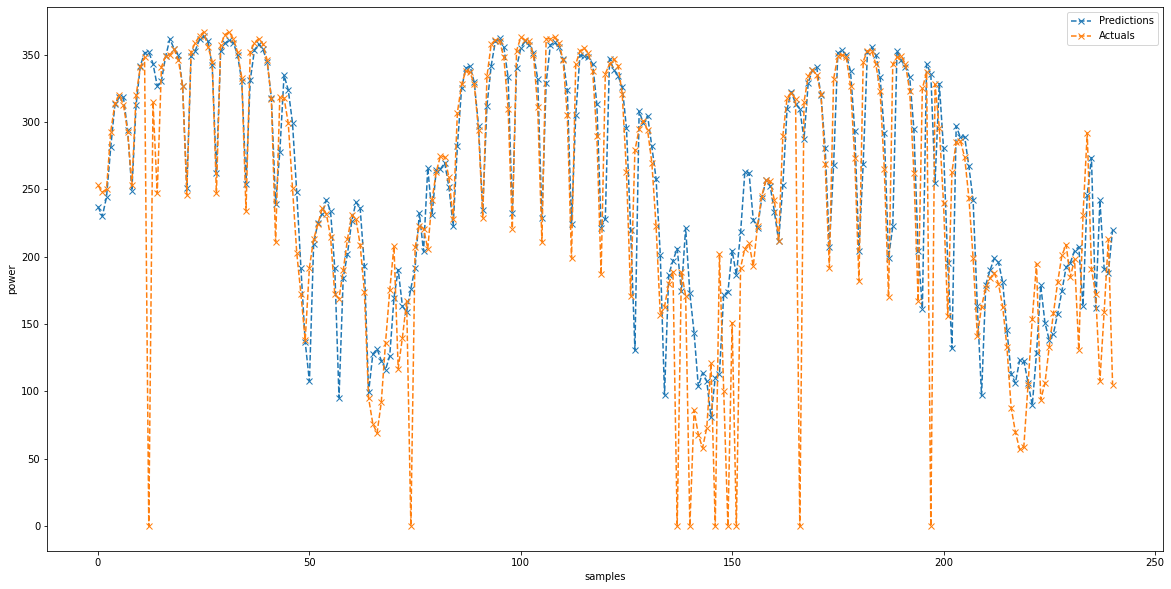

In [169]:
plot_predictions(model, X_test, y_test, start=0, end=100)